In [2]:
 #============================ Energy_space_simulation.py=========================#
# %%    
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#%% 1) Physical constants 
c    = 2.99792458e8        # m/s
m    = 9.109383e-31        # kg
e    = 1.60217662e-19      # C
hbar = 1.054571800e-34     # J·s
eps0 = 8.854187817e-12     # F/m


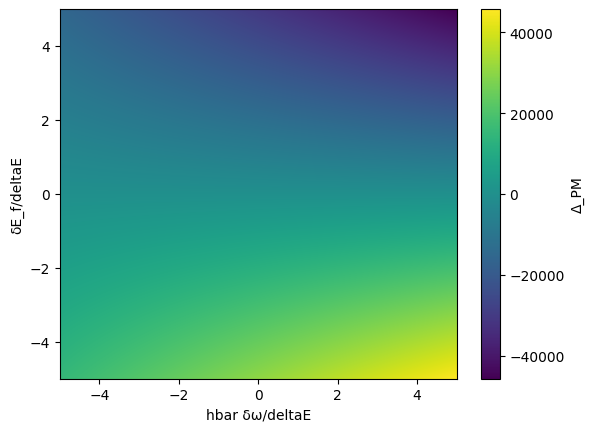

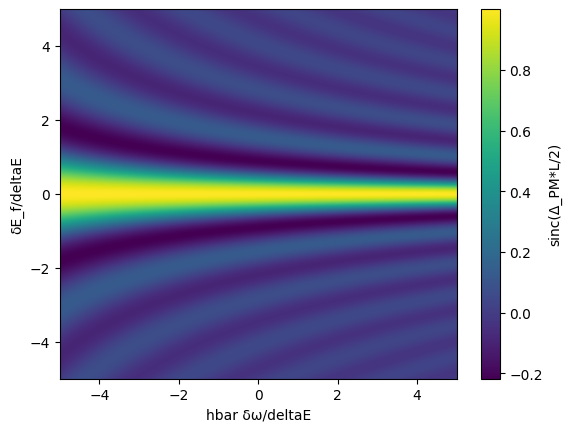

In [ ]:
#%% 2) Electron parameters 

v0     = 0.1 * c                                # electron carrier velocity
E0     = 0.5 * m * v0**2                        # central electron energy (J)



#%% 3) Photon parameters 
lambda0 = 500e-9                                # central wavelength (m)
omega0  = 2 * np.pi * c / lambda0               # central angular frequency (rad/s)
v_g     = (0.10000 +0.00000)* c                 # photon group velocity (m/s)


deltaE = 0.1 * hbar * omega0                    # energy spread (J)


k0     = np.sqrt(2 * m * E0) / hbar             # central momentum (1/m)
k0_m_hw     = np.sqrt(2 * m * (E0-hbar *omega0)) / hbar
q0 = k0 - k0_m_hw



# From Phase‐matching expansion (approximation) to fit LINEAR dispersion relations:
#q0     =  (k(E0) - k(E0 - hbar*omega0))                     # from Phase matching
recoil = (-1 / (k0 * v0**2))                                  # second‐order term

#
q0_pertubation     =  ((omega0/v0)+(1/(2*k0))*((omega0/v0)**2))  
# Define conversion functions:

def q(δω):
    return q0 + (δω / v_g) + 0.5 * recoil * δω**2
def k(E):
    return np.sqrt(2 * m * E) / hbar




#%% 4) Interaction length and derived quantities
         # interaction length (m)

lambdaDB = 2 * np.pi  / k0 # de Broglie wavelength (m)
# critical length for cooling (m)
L_critical = (4/np.pi)*lambdaDB*(E0/deltaE)**2  
L_int = 0.5*L_critical  
T     = L_int / v0     # interaction time (s)
# Phase mathcing condition:
Δk0 = k(E0 - hbar*omega0) - k(E0) - q(omega0) 

#%% 5) Grids - Energy and frequency  

# for adaptation:
def Energy_from_momentum(k):
    return (hbar * k)**2 / (2 * m)  # Energy from momentum k
N = 2**12
# --- ENERGY GRID
N_E   = N    # number of energy points
#E_min = Energy_from_momentum(0.95 *k0)
#E_max = Energy_from_momentum(1.05 *k0)

E_min = E0 - 5*deltaE
E_max = E0 + 5*deltaE

E_f   = np.linspace(E_min, E_max, N_E)
dE    = E_f[1] - E_f[0]
energy_span = E_max - E_min

δE_f =  E_f - E0



# --- FREQUENCY GRID - CORRECTED
N_ω = N
omega_span = 10 * deltaE / hbar  # Narrow span around ω₀
ω_min = max(omega0 - omega_span/2 , 0*omega0)  # Start from ω₀ - span/2
ω_max = omega0 + omega_span/2   # End at ω₀ + span/2
ω_vec = np.linspace(ω_min, ω_max, N_ω)
dω = ω_vec[1] - ω_vec[0]

δω = ω_vec - omega0

δω_grid, δE_f_grid = np.meshgrid(δω, δE_f)
Delta_PM = k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - q(δω_grid)




# Plot 2D heatmap

plt.imshow(Delta_PM, extent=[hbar*δω.min()/deltaE, hbar*δω.max()/deltaE, δE_f.min()/deltaE, δE_f.max()/deltaE],
           origin='lower', aspect='auto')
plt.xlabel("hbar δω/deltaE")
plt.ylabel("δE_f/deltaE")
plt.colorbar(label="Δ_PM")
plt.show()



plt.imshow(np.sinc(Delta_PM*L_int/2/np.pi), extent=[hbar*δω.min()/deltaE, hbar*δω.max()/deltaE, δE_f.min()/deltaE, δE_f.max()/deltaE],
           origin='lower', aspect='auto')
plt.xlabel("hbar δω/deltaE")
plt.ylabel("δE_f/deltaE")
plt.colorbar(label="sinc(Δ_PM*L/2)")
plt.show()


plt.imshow(np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2), extent=[hbar*δω.min()/deltaE, hbar*δω.max()/deltaE, δE_f.min()/deltaE, δE_f.max()/deltaE],
           origin='lower', aspect='auto')
plt.xlabel("hbar δω/deltaE")
plt.ylabel("δE_f/deltaE")
plt.colorbar(label="sinc(Δ_PM*L/2)")
plt.show()




plt.imshow(np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2)*(np.sinc(Delta_PM*L_int/2/np.pi))**2, extent=[hbar*δω.min()/deltaE, hbar*δω.max()/deltaE, δE_f.min()/deltaE, δE_f.max()/deltaE],
           origin='lower', aspect='auto')
plt.xlabel("hbar δω/deltaE")
plt.ylabel("δE_f/deltaE")
plt.colorbar(label="sinc(Δ_PM*L/2)")
plt.show()




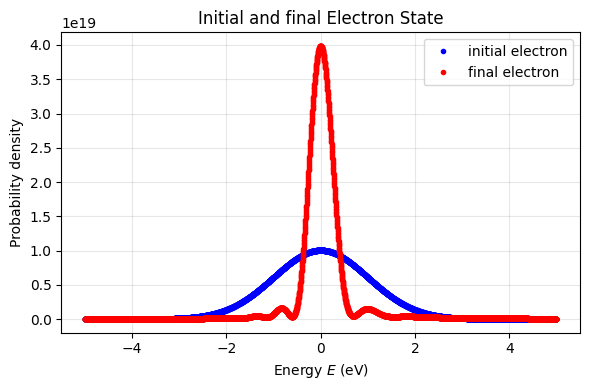

In [ ]:


rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2))*np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2)*(np.sinc(Delta_PM*L_int/2/np.pi))**2,axis = 1)*dω
rho_f = rho_f/ np.sum(rho_f*dE)  # Normalize the final state probability density
rho_i = np.exp(-δE_f**2/2/deltaE**2)/ np.sqrt(2*np.pi*deltaE**2)  # Initial state probability density
plt.figure(figsize=(6,4))

plt.plot((E_f - E0)/deltaE, rho_i, '.', label="initial electron", color='blue')
plt.plot((E_f - E0)/deltaE, rho_f,  '.', label="final electron", color='red')

plt.xlabel("Energy $E$ (eV)")
plt.ylabel("Probability density")
plt.title("Initial and final Electron State")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


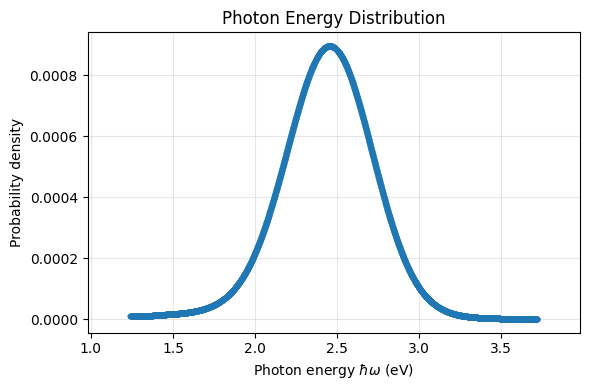

In [43]:
# 11) Photon‐frequency (“photon wavefunction”) distribution
photon_prob_ω = np.sum((1/np.sqrt(2*np.pi*deltaE**2))*np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2)*(np.sinc(Delta_PM*L_int/2/np.pi))**2,axis = 0)*dE
# Normalize the photon probability distribution
photon_prob_ω = photon_prob_ω / np.sum(photon_prob_ω *dω)  # Normalize the final state probability density
if np.sum(photon_prob_ω) > 0:
    photon_prob_ω /= ( np.sum(photon_prob_ω)  )

# Convert ω → photon‐energy in eV:  E_γ = ħ·ω / e
photon_energy_eV = (hbar * ω_vec) / e

plt.figure(figsize=(6,4))
plt.plot(photon_energy_eV, photon_prob_ω, '.', lw=2,)
plt.xlabel("Photon energy $ħω$ (eV)")
plt.ylabel("Probability density")
plt.title("Photon Energy Distribution")
plt.grid(True, alpha=0.3)
# Zoom: show ±0.5 eV around ħω₀
center_eV = hbar * omega0 / e
plt.xlim(center_eV - 1.5, center_eV + 1.5)
plt.tight_layout()

In [44]:
# Compute final FWHM
initial_width = compute_FWHM(E_f, rho_i)
final_width = compute_FWHM(E_f, rho_f)

# Find peak positions for initial and final distributions
initial_peak_idx = np.argmax(rho_i)
final_peak_idx = np.argmax(rho_f)
initial_peak_E = E_f[initial_peak_idx]
final_peak_E = E_f[final_peak_idx]
peak_shift = (final_peak_E - initial_peak_E)
peak_shift_eV = peak_shift / e  # Convert to eV
max_idx = np.argmax(photon_prob_ω)
max_photon_energy = photon_energy_eV[max_idx]


# 12) Final summary print
print(" SIMULATION SUMMARY ".center(50, "="))
print(f"Peak shift:              {peak_shift_eV:.4e} eV")
print(f"Central electron energy: {E0/e:.2e} eV")
print(f"Energy spread ΔE:        {deltaE/e:.2e} eV  ({deltaE/E0:.1%} of E0)")
print(f"Interaction length L:    {L_int*1e3:.2f} mm")
# print(f"Critical length :        {L_critical*1e9:.2f} nm")
print(f"Initial FWHM:            {initial_width/e:.4e} eV  ({initial_width/E0:.4e} E0)")
print(f"Final   FWHM:            {final_width/e:.4e} eV  ({final_width/E0:.4e} E0)")
print(f"photon central energy:   {max_photon_energy:.4f} eV")
print("="*50 + "\n")


=============== SIMULATION SUMMARY ===============
Peak shift:              6.0554e-04 eV
Central electron energy: 2.55e+03 eV
Energy spread ΔE:        2.48e-01 eV  (0.0% of E0)
Interaction length L:    1.64 mm
Initial FWHM:            5.8313e-01 eV  (2.2823e-04 E0)
Final   FWHM:            1.3746e-01 eV  (5.3800e-05 E0)
photon central energy:   2.4546 eV




 WIDTH vs LENGTH SCAN 
Testing L = 328.0 μm
Testing L = 773.1 μm
Testing L = 1218.2 μm
Testing L = 1663.3 μm
Testing L = 2108.4 μm
Testing L = 2553.5 μm
Testing L = 2998.6 μm
Testing L = 3443.8 μm
Testing L = 3888.9 μm
Testing L = 4334.0 μm
Testing L = 4779.1 μm
Testing L = 5224.2 μm
Testing L = 5669.3 μm
Testing L = 6114.4 μm
Testing L = 6559.5 μm


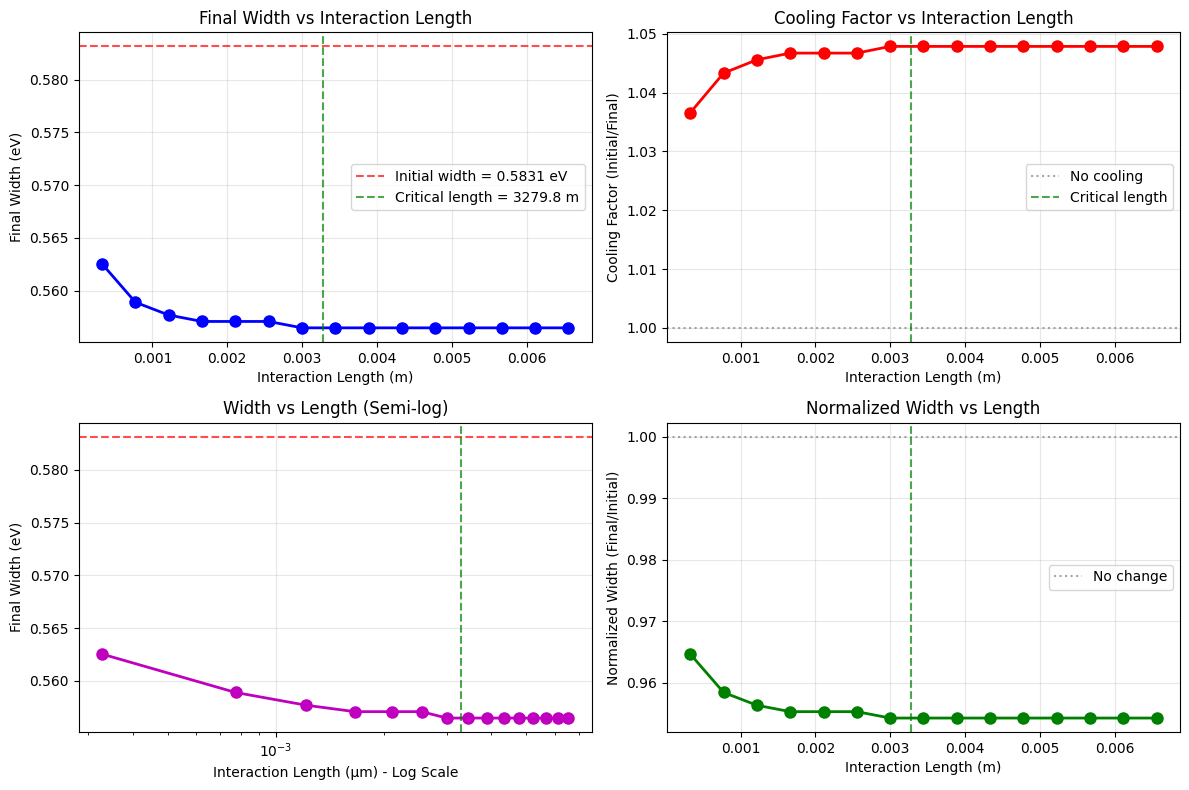


 SCAN RESULTS 
3279.77294414615 μm
Length (m)   Width (eV)   Cooling Factor  Normalized  
------------------------------------------------------------
0.0          0.5625       1.04            0.965       
0.0          0.5589       1.04            0.958       
0.0          0.5577       1.05            0.956       
0.0          0.5571       1.05            0.955       
0.0          0.5571       1.05            0.955       
0.0          0.5571       1.05            0.955       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       
0.0          0.5565       1.05            0.954       

Best cooling: 1.05× at

In [68]:
#%% Simple Width vs. Interaction Length Scan
print("\n" + "="*50)
print(" WIDTH vs LENGTH SCAN ")
print("="*50)

# Define 10 relevant interaction lengths
L_test_vec = np.linspace(0.1 * L_critical, 2 * L_critical, 15)  # m
widths = []
for L in L_test_vec:
    print(f"Testing L = {L*1e6:.1f} μm")    
    rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2))*np.exp(-(δE_f_grid + hbar*δω_grid)**2/2/deltaE**2)*(np.sinc(Delta_PM*(L/2)/np.pi))**2,axis = 1)*dω
    rho_f = rho_f/ np.sum(rho_f*dE)  # Normalize the final state probability density
    rho_i = np.exp(-δE_f**2/2/deltaE**2)/ np.sqrt(2*np.pi*deltaE**2)  # Initial state probability density   
    # Compute final FWHM
    initial_width = compute_FWHM(E_f, rho_i)
    final_width = compute_FWHM(E_f, rho_f)
    cooling_factor = (initial_width / e) / (final_width / e)
    widths.append(final_width / e)  # Store final width in eV
    # plt.plot((E_f - E0)/deltaE, rho_f,  '.', label="final electron")
# plt.show()
    

final_widths_eV = np.array(widths)

# Calculate cooling factors
cooling_factors = (initial_width/e) / final_widths_eV

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Width vs Length
ax1.plot(L_test_vec, final_widths_eV, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=initial_width/e, color='r', linestyle='--', alpha=0.7, 
            label=f'Initial width = {initial_width/e:.4f} eV')
ax1.axvline(x=L_critical, color='g', linestyle='--', alpha=0.7, 
            label=f'Critical length = {L_critical*1e6:.1f} m')
ax1.set_xlabel('Interaction Length (m)')
ax1.set_ylabel('Final Width (eV)')
ax1.set_title('Final Width vs Interaction Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cooling Factor vs Length
ax2.plot(L_test_vec, cooling_factors, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=1, color='gray', linestyle=':', alpha=0.7, label='No cooling')
ax2.axvline(x=L_critical, color='g', linestyle='--', alpha=0.7, 
            label=f'Critical length')
ax2.set_xlabel('Interaction Length (m)')
ax2.set_ylabel('Cooling Factor (Initial/Final)')
ax2.set_title('Cooling Factor vs Interaction Length')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Log scale
ax3.semilogx(L_test_vec, final_widths_eV, 'mo-', linewidth=2, markersize=8)
ax3.axhline(y=initial_width/e, color='r', linestyle='--', alpha=0.7)
ax3.axvline(x=L_critical, color='g', linestyle='--', alpha=0.7)
ax3.set_xlabel('Interaction Length (μm) - Log Scale')
ax3.set_ylabel('Final Width (eV)')
ax3.set_title('Width vs Length (Semi-log)')
ax3.grid(True, alpha=0.3)

# Plot 4: Normalized width
ax4.plot(L_test_vec, final_widths_eV / (initial_width/e), 'go-', linewidth=2, markersize=8)
ax4.axhline(y=1, color='gray', linestyle=':', alpha=0.7, label='No change')
ax4.axvline(x=L_critical, color='g', linestyle='--', alpha=0.7)
ax4.set_xlabel('Interaction Length (m)')
ax4.set_ylabel('Normalized Width (Final/Initial)')
ax4.set_title('Normalized Width vs Length')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results summary
print("\n" + "="*60)
print(" SCAN RESULTS ")
print("="*60)
print(L_critical*1e6 , "μm")
print(f"{'Length (m)':<12} {'Width (eV)':<12} {'Cooling Factor':<15} {'Normalized':<12}")
print("-" * 60)
for i in range(len(L_test_vec)):
    normalized = final_widths_eV[i] / (initial_width/e)
    print(f"{L_test_vec[i]:<12.1f} {final_widths_eV[i]:<12.4f} {cooling_factors[i]:<15.2f} {normalized:<12.3f}")

# Find best performance
best_idx = np.argmax(cooling_factors)
print(f"\nBest cooling: {cooling_factors[best_idx]:.2f}× at L = {L_test_vec[best_idx]:.1f} μm")
print(f"Minimum width: {final_widths_eV[best_idx]:.4f} eV")
print("="*60)


In [49]:
L_test_um

array([  257.59276467,   515.18552934,  1287.96382335,  2060.74211735,
        2575.92764669,  3863.89147004,  5151.85529339,  7727.78294008,
       12879.63823347, 25759.27646693])

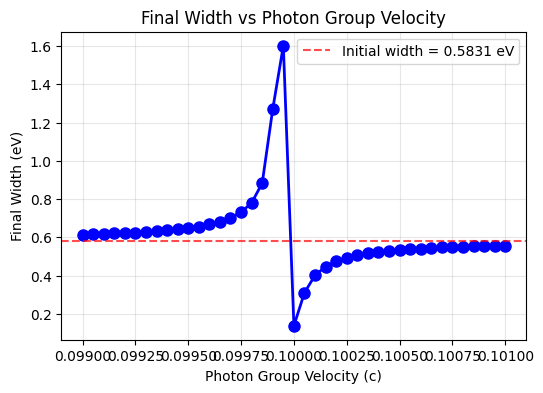

In [69]:
# differnt group velocities of the photon:
v_g_vec = np.linspace(0.099, 0.101, 41) * c 
widths_vg = []
for v_g_test in v_g_vec:
    Delta_PM = k(E0 + δE_f_grid + hbar*δω_grid) - k(E0 + δE_f_grid - hbar*omega0) - (q0 + (δω_grid/ v_g_test) + 0.5 * recoil * δω_grid**2)
    
    rho_f = np.sum((1/np.sqrt(2*np.pi*deltaE**2)) * np.exp(-(δE_f_grid + hbar*δω_grid)**2 / (2 * deltaE**2)) * 
                   (np.sinc(Delta_PM * L_int / 2 / np.pi))**2, axis=1) * dω
    rho_f /= np.sum(rho_f * dE)  # Normalize the final state probability density
    rho_i = np.exp(-δE_f**2 / (2 * deltaE**2)) / np.sqrt(2 * np.pi * deltaE**2)  # Initial state probability density
    
    # Compute final FWHM
    initial_width = compute_FWHM(E_f, rho_i)
    final_width = compute_FWHM(E_f, rho_f)
    
    widths_vg.append(final_width / e)  # Store final width in eV
    # plt.plot((E_f - E0)/deltaE, rho_f,  '.', label=f"{v_g_test/c}")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()
    
plt.figure(figsize=(6, 4))
plt.plot(v_g_vec / c, widths_vg, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=initial_width / e, color='r', linestyle='--', alpha=0.7, 
            label=f'Initial width = {initial_width/e:.4f} eV')      
plt.xlabel('Photon Group Velocity (c)')
plt.ylabel('Final Width (eV)')
plt.title('Final Width vs Photon Group Velocity')
plt.legend()    
plt.grid(True, alpha=0.3)
